# **LAB5:Implement convolutional operations and analyze feature maps**

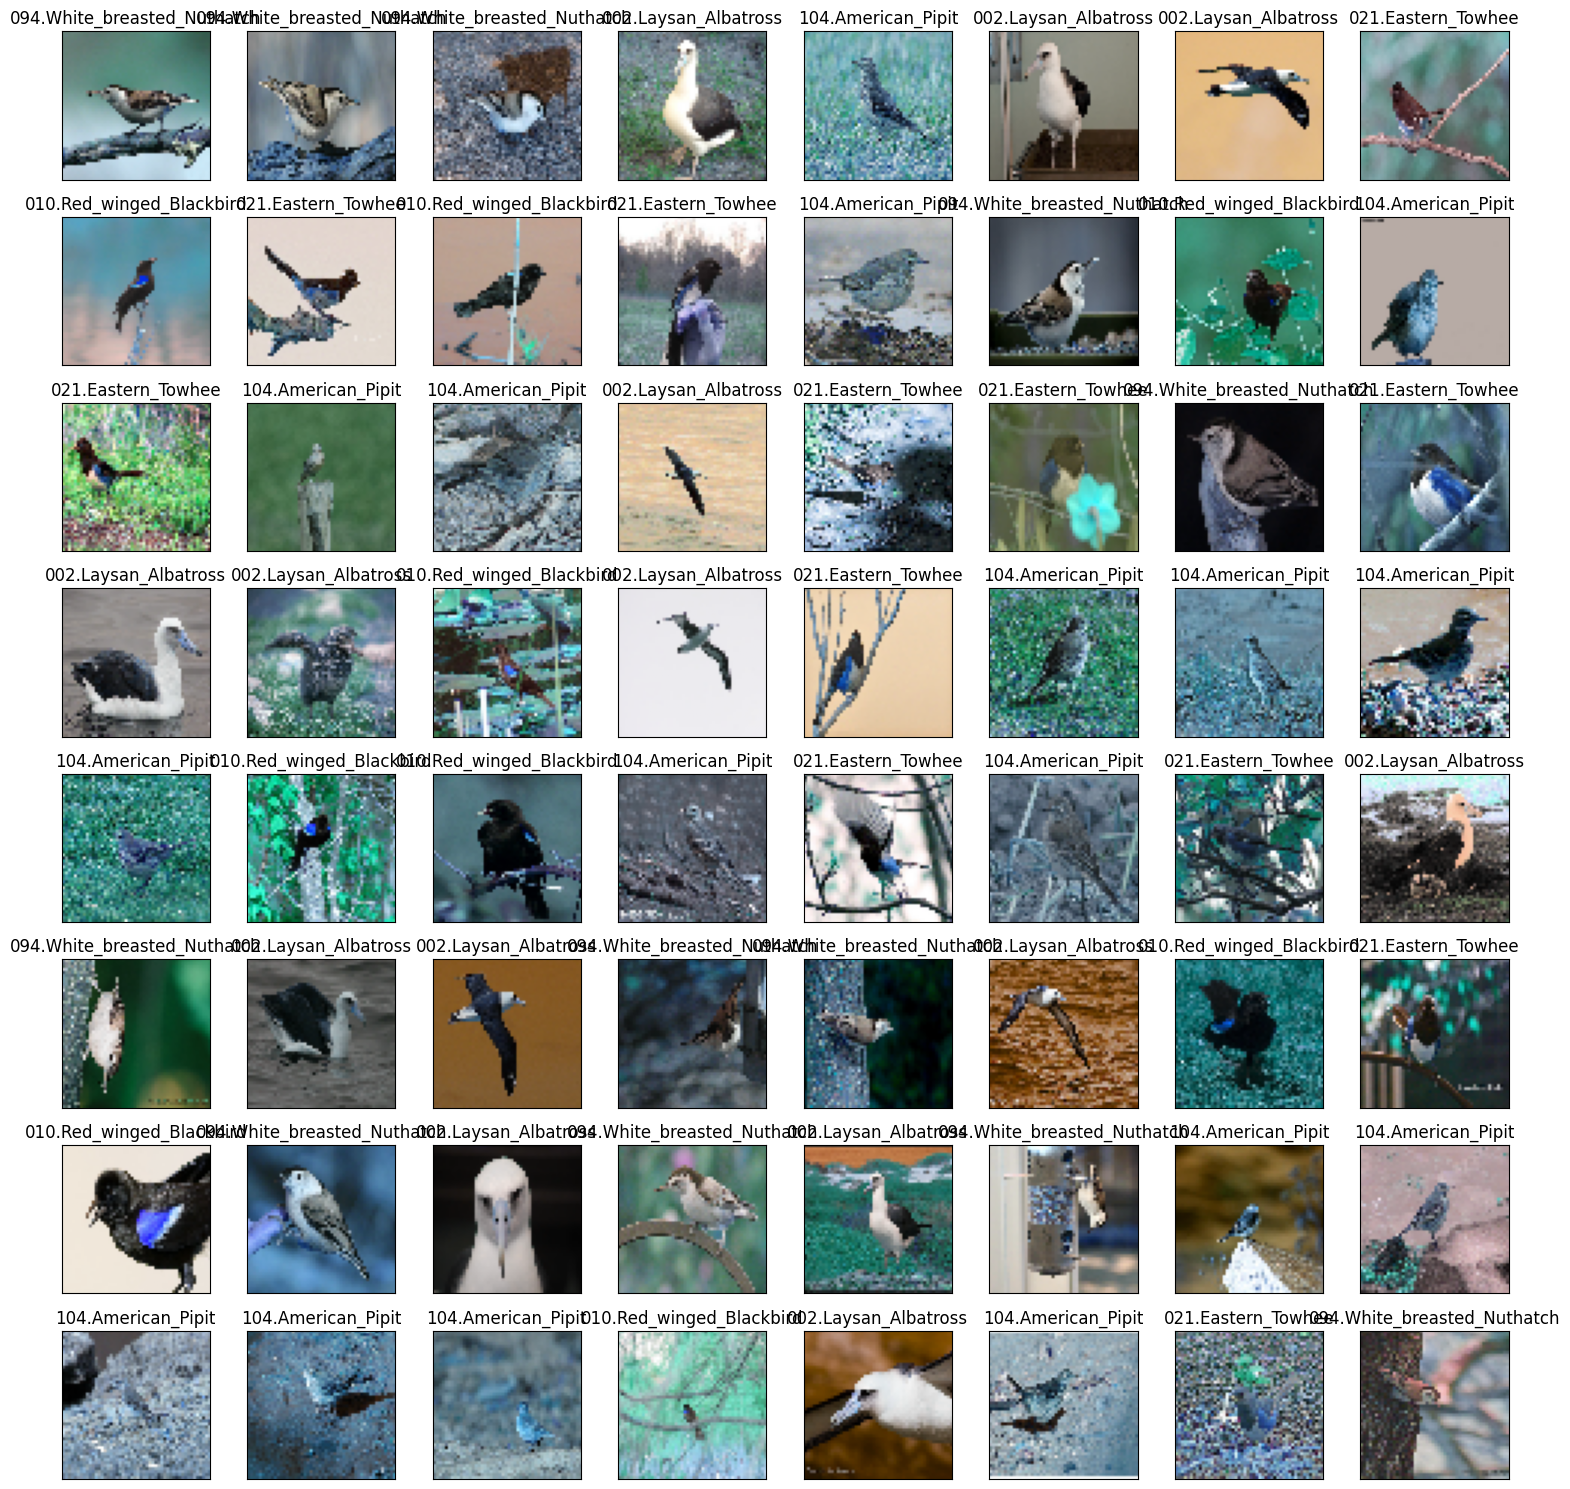

In [81]:
import matplotlib.pyplot as plt

class_names = [
    '002.Laysan_Albatross',
    '010.Red_winged_Blackbird',
    '021.Eastern_Towhee',
    '094.White_breasted_Nuthatch',
    '104.American_Pipit'
]

plt.figure(figsize=(15, 15))

for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    plt.title(class_names[y_train[i]], fontsize=12)

plt.tight_layout()
plt.show()


In [114]:
import os, cv2, numpy as np, random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2

In [115]:
IMG_SIZE = 50
NUM_CLASSES = 5
batch_size = 16
epochs = 300
data_path = "/content/drive/MyDrive/Image_Dataset"

In [116]:
label_map = {
    '002.Laysan_Albatross': 0,
    '010.Red_winged_Blackbird': 1,
    '021.Eastern_Towhee': 2,
    '094.White_breasted_Nuthatch': 3,
    '104.American_Pipit': 4
}


In [117]:
# Data augmentation function
def simple_augment(img):
    if random.random() < 0.5:
        img = cv2.flip(img, 1)
    angle = random.uniform(-15, 15)
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
    img = cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT_101)
    zoom = random.uniform(0.9, 1.1)
    nh, nw = int(h * zoom), int(w * zoom)
    img = cv2.resize(img, (nw, nh))
    if zoom > 1:
        startx, starty = (nw - w)//2, (nh - h)//2
        img = img[starty:starty+h, startx:startx+w]
    else:
        padx, pady = (w - nw)//2, (h - nh)//2
        img = cv2.copyMakeBorder(img, pady, h-nh-pady, padx, w-nw-padx, cv2.BORDER_REFLECT_101)
    img = np.clip(img * random.uniform(0.9, 1.1), 0, 255).astype(np.uint8)
    return img

In [118]:
def load_and_augment(data_path):
    X, y = [], []
    for label_name in os.listdir(data_path):
        folder_path = os.path.join(data_path, label_name)
        if os.path.isdir(folder_path):
            label = label_map[label_name]
            for fname in os.listdir(folder_path):
                if fname.endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(folder_path, fname)
                    img = cv2.imread(img_path)
                    if img is None: continue
                    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                    X.append(img)
                    y.append(label)
                    # Add one augmented copy
                    aug_img = simple_augment(img.copy())
                    X.append(aug_img)
                    y.append(label)
    return np.array(X, dtype='float32') / 255.0, np.array(y)

In [119]:
X_all, y_all = load_and_augment(data_path)
print(f"Total images after augmentation: {len(X_all)}")

Total images after augmentation: 600


In [120]:
X_train, X_temp, y_train, y_temp = train_test_split(X_all, y_all, test_size=0.2, stratify=y_all, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [121]:
# Normalize using training stats
mean = np.mean(X_train)
std = np.std(X_train)
X_train = (X_train - mean) / (std + 1e-7)
X_valid = (X_valid - mean) / (std + 1e-7)
X_test  = (X_test - mean)  / (std + 1e-7)

In [122]:
# One-hot encode labels
y_train = to_categorical(y_train, NUM_CLASSES)
y_valid = to_categorical(y_valid, NUM_CLASSES)
y_test  = to_categorical(y_test, NUM_CLASSES)

print(f"Train: {X_train.shape}, Valid: {X_valid.shape}, Test: {X_test.shape}")

Train: (480, 50, 50, 3), Valid: (60, 50, 50, 3), Test: (60, 50, 50, 3)


In [123]:
# Build CNN model
model = Sequential()
wd = 0.0001

model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_regularizer=l2(wd), input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_regularizer=l2(wd)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding='same', activation='relu', kernel_regularizer=l2(wd)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', activation='relu', kernel_regularizer=l2(wd)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(NUM_CLASSES, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [132]:
model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_76 (Conv2D)              │ (None, 50, 50, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_76          │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (None, 50, 50, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_77          │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_78 (Conv2D)              │ (None, 25, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_78          │ (None, 25, 25, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_79 (Conv2D)              │ (None, 25, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_79          │ (None, 25, 25, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 5)              │        46,085 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 336,497 (1.28 MB)

 Trainable params: 112,037 (437.64 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 224,076 (875.30 KB)

In [124]:
# Compile model
model.compile(optimizer=Adam(learning_rate=2.5e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [125]:
# Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5),
    EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, verbose=1)
]

In [126]:
# Train model (no generator needed now)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=2
)

Epoch 1/300
30/30 - 14s - 457ms/step - accuracy: 0.3187 - loss: 2.5278 - val_accuracy: 0.4167 - val_loss: 1.5389 - learning_rate: 2.5000e-04
Epoch 2/300
30/30 - 11s - 379ms/step - accuracy: 0.5583 - loss: 1.4116 - val_accuracy: 0.4500 - val_loss: 1.5030 - learning_rate: 2.5000e-04
Epoch 3/300
30/30 - 8s - 265ms/step - accuracy: 0.6667 - loss: 0.9843 - val_accuracy: 0.3667 - val_loss: 1.4359 - learning_rate: 2.5000e-04
Epoch 4/300
30/30 - 11s - 381ms/step - accuracy: 0.7417 - loss: 0.7155 - val_accuracy: 0.3500 - val_loss: 1.3744 - learning_rate: 2.5000e-04
Epoch 5/300
30/30 - 12s - 403ms/step - accuracy: 0.7958 - loss: 0.5894 - val_accuracy: 0.2833 - val_loss: 1.4674 - learning_rate: 2.5000e-04
Epoch 6/300
30/30 - 18s - 598ms/step - accuracy: 0.8542 - loss: 0.4389 - val_accuracy: 0.4000 - val_loss: 1.3110 - learning_rate: 2.5000e-04
Epoch 7/300
30/30 - 12s - 395ms/step - accuracy: 0.9312 - loss: 0.2567 - val_accuracy: 0.5167 - val_loss: 1.2269 - learning_rate: 2.5000e-04
Epoch 8/300
30

In [127]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {acc:.4f} | Test Loss: {loss:.4f}")

Test Accuracy: 0.7333 | Test Loss: 0.9200


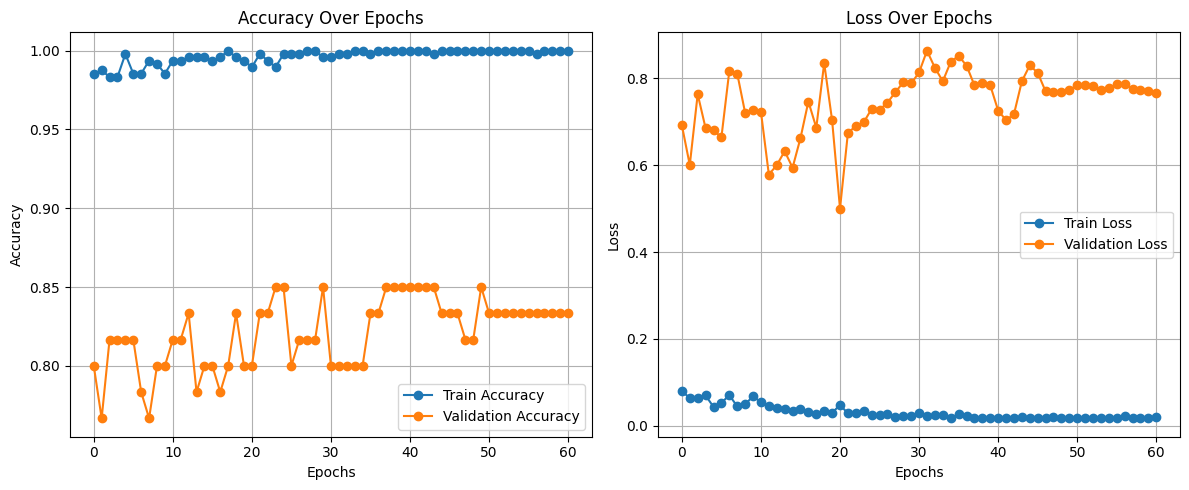

In [133]:
import matplotlib.pyplot as plt

# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


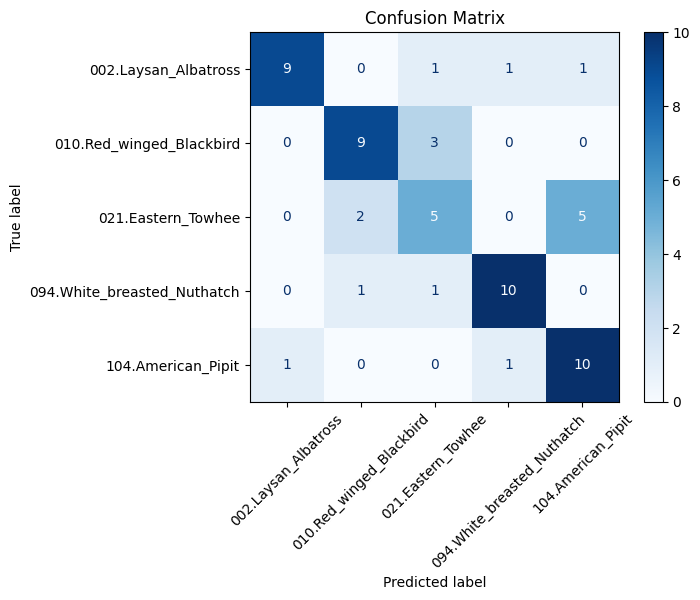

In [134]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_map.keys())
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


In [135]:
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=label_map.keys()))

Classification Report:
                             precision    recall  f1-score   support

       002.Laysan_Albatross       0.90      0.75      0.82        12
   010.Red_winged_Blackbird       0.75      0.75      0.75        12
         021.Eastern_Towhee       0.50      0.42      0.45        12
094.White_breasted_Nuthatch       0.83      0.83      0.83        12
         104.American_Pipit       0.62      0.83      0.71        12

                   accuracy                           0.72        60
                  macro avg       0.72      0.72      0.71        60
               weighted avg       0.72      0.72      0.71        60



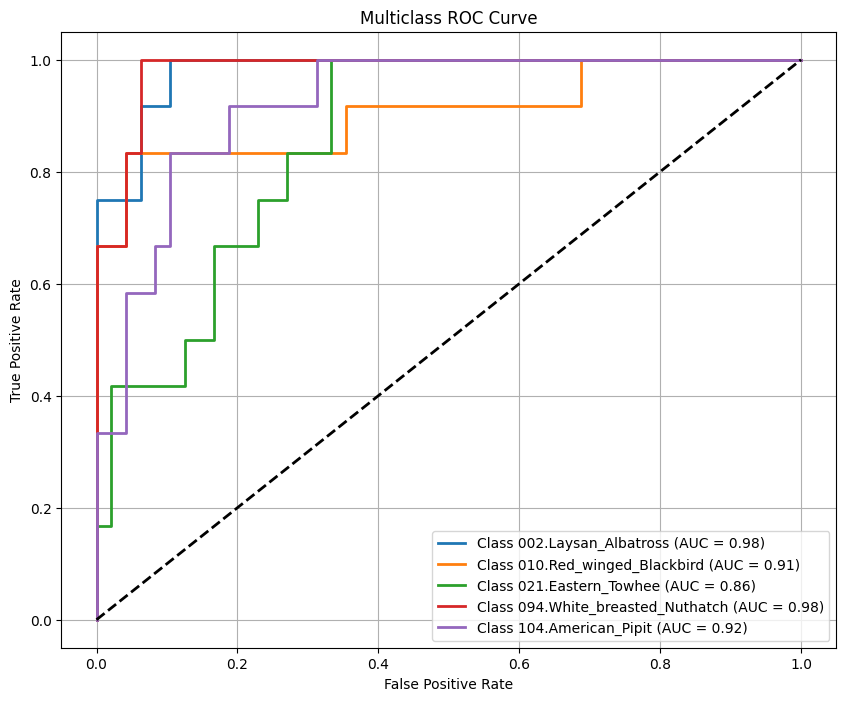

In [136]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize labels
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4])
n_classes = NUM_CLASSES

# Plot ROC
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {list(label_map.keys())[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
